# Steam AU Reviews & Items

## Introduction

### Predictive task
***Given a user's past sequence of games, what is the next game they buy?***

The **input** features for our model include:
* Hours played
* Number of sessions
* Game genre
* Review text
* Basic user history

Note: Review text refers to processed user reviews through TF-IDF vectorization and analyzing sentiment scores. Basic user history refers to a user's past recommendation rate and what games already exist in their Steam library. 

The **output** of our model is a binary label (1 - recommend, 0 - not recommend) indicating whether the user recommends the game or not. This task is appropriate for supervised learning and aligns directly with models covered in the course.

### Plans: Baselines and Evaluation

We plan to use the following baseline models:
* Random baseline
* Logistic regression
* Naive Bayes

We plan to evaluate these models by comparing these metrics:
* Accuracy
* F1 score

## Imports & Setup

In [1]:
# Loading data
import gzip
import ast
from pathlib import Path

# Essentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Preprocessing & Splitting
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

# Pipelines & Feature Combos
from sklearn.pipeline import make_pipeline, FeatureUnion

# Models
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# Evaluation
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [2]:
DATA_DIR = Path('data')

def load_python_dicts_gz(path: Path, max_rows=None, verbose=True) -> pd.DataFrame:
    rows = []
    with gzip.open(path, 'rt', encoding='utf-8') as f:
        for i, line in enumerate(f, start=1):
            line = line.strip()
            if not line:
                continue
            rows.append(ast.literal_eval(line))
            if max_rows is not None and len(rows) >= max_rows:
                break
            if verbose and i % 100_000 == 0:
                print(f"Read {i} lines from {path.name}...")

    df = pd.json_normalize(rows)
    return df

In [3]:
# Load user reviews data
reviews_path = DATA_DIR / 'australian_user_reviews.json.gz'
reviews = load_python_dicts_gz(reviews_path, max_rows=100_000)

print('reviews shape:', reviews.shape)
print('reviews columns:')
print(list(reviews.columns))

reviews.head()

reviews shape: (25799, 3)
reviews columns:
['user_id', 'user_url', 'reviews']


,user_id,user_url,reviews
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'funny': '', 'posted': 'Posted November 5, 2..."
1,js41637,http://steamcommunity.com/id/js41637,"[{'funny': '', 'posted': 'Posted June 24, 2014..."
2,evcentric,http://steamcommunity.com/id/evcentric,"[{'funny': '', 'posted': 'Posted February 3.',..."
3,doctr,http://steamcommunity.com/id/doctr,"[{'funny': '', 'posted': 'Posted October 14, 2..."
4,maplemage,http://steamcommunity.com/id/maplemage,"[{'funny': '3 people found this review funny',..."


In [4]:
# Load user items data
items_path = DATA_DIR / 'australian_users_items.json.gz'
items = load_python_dicts_gz(items_path, max_rows=100)

print('items shape:', items.shape)
print('items columns:')
print(list(items.columns))

items.head()

items shape: (100, 5)
items columns:
['user_id', 'items_count', 'steam_id', 'user_url', 'items']


,user_id,items_count,steam_id,user_url,items
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
1,js41637,888,76561198035864385,http://steamcommunity.com/id/js41637,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
2,evcentric,137,76561198007712555,http://steamcommunity.com/id/evcentric,"[{'item_id': '1200', 'item_name': 'Red Orchest..."
3,Riot-Punch,328,76561197963445855,http://steamcommunity.com/id/Riot-Punch,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
4,doctr,541,76561198002099482,http://steamcommunity.com/id/doctr,"[{'item_id': '300', 'item_name': 'Day of Defea..."


## Preprocessing Data

### What does each value in the reviews column represent in the ``reviews`` dataframe?

In [5]:
from pprint import pprint

review_list = reviews['reviews'].iloc[0]
print(type(review_list))

pprint(review_list)

<class 'list'>
[{'funny': '',
  'helpful': 'No ratings yet',
  'item_id': '1250',
  'last_edited': '',
  'posted': 'Posted November 5, 2011.',
  'recommend': True,
  'review': 'Simple yet with great replayability. In my opinion does "zombie" '
            'hordes and team work better than left 4 dead plus has a global '
            'leveling system. Alot of down to earth "zombie" splattering fun '
            'for the whole family. Amazed this sort of FPS is so rare.'},
 {'funny': '',
  'helpful': 'No ratings yet',
  'item_id': '22200',
  'last_edited': '',
  'posted': 'Posted July 15, 2011.',
  'recommend': True,
  'review': "It's unique and worth a playthrough."},
 {'funny': '',
  'helpful': 'No ratings yet',
  'item_id': '43110',
  'last_edited': '',
  'posted': 'Posted April 21, 2011.',
  'recommend': True,
  'review': 'Great atmosphere. The gunplay can be a bit chunky at times but at '
            'the end of the day this game is definitely worth it and I hope '
            'they 

In [6]:
first_review = review_list[0]
pprint(first_review)

{'funny': '',
 'helpful': 'No ratings yet',
 'item_id': '1250',
 'last_edited': '',
 'posted': 'Posted November 5, 2011.',
 'recommend': True,
 'review': 'Simple yet with great replayability. In my opinion does "zombie" '
           'hordes and team work better than left 4 dead plus has a global '
           'leveling system. Alot of down to earth "zombie" splattering fun '
           'for the whole family. Amazed this sort of FPS is so rare.'}


### What about the items column in the ``items`` dataframe?

In [7]:
item_list = items['items'].iloc[0]
print(type(item_list))

item_list

<class 'list'>


[{'item_id': '10',
  'item_name': 'Counter-Strike',
  'playtime_forever': 6,
  'playtime_2weeks': 0},
 {'item_id': '20',
  'item_name': 'Team Fortress Classic',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '30',
  'item_name': 'Day of Defeat',
  'playtime_forever': 7,
  'playtime_2weeks': 0},
 {'item_id': '40',
  'item_name': 'Deathmatch Classic',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '50',
  'item_name': 'Half-Life: Opposing Force',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '60',
  'item_name': 'Ricochet',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '70',
  'item_name': 'Half-Life',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '130',
  'item_name': 'Half-Life: Blue Shift',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '300',
  'item_name': 'Day of Defeat: Source',
  'playtime_forever': 4733,
  'playtime_2weeks': 0},
 {'item_id': '240',
  'item_name': 'Counter-Strike: S

In [8]:
first_item = item_list[0]
pprint(first_item)

{'item_id': '10',
 'item_name': 'Counter-Strike',
 'playtime_2weeks': 0,
 'playtime_forever': 6}


It seems that each value in the reviews column and items column are both lists of dictionaries. In the reviews column, each value is a dictionary of reviews for different games. In the items column, each value is a dictionary of items, or games, for different Steam users.

It's a bit hard to read each review from a user, especially if they leave a lot of reviews. We can explode the list of reviews to make it easier to read. We will also do the same thing for items.

In [9]:
# Explode list of reviews so each review gets its own row
reviews_long = reviews.explode('reviews').reset_index(drop = True)

# Split each dictionary key into separate columns
review_details = pd.json_normalize(reviews_long['reviews'])

reviews_long = pd.concat(
    [reviews_long.drop(columns = ['reviews']), review_details],
    axis = 1
)

reviews_long.head()

,user_id,user_url,funny,posted,last_edited,item_id,helpful,recommend,review
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted November 5, 2011.",,1250,No ratings yet,True,Simple yet with great replayability. In my opi...
1,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted July 15, 2011.",,22200,No ratings yet,True,It's unique and worth a playthrough.
2,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted April 21, 2011.",,43110,No ratings yet,True,Great atmosphere. The gunplay can be a bit chu...
3,js41637,http://steamcommunity.com/id/js41637,,"Posted June 24, 2014.",,251610,15 of 20 people (75%) found this review helpful,True,I know what you think when you see this title ...
4,js41637,http://steamcommunity.com/id/js41637,,"Posted September 8, 2013.",,227300,0 of 1 people (0%) found this review helpful,True,For a simple (it's actually not all that simpl...


In [10]:
items_long = items.explode("items").reset_index(drop=True)

item_details = pd.json_normalize(items_long["items"])
items_long = pd.concat(
    [items_long.drop(columns=["items"]), item_details],
    axis=1
)

items_long.head()

,user_id,items_count,steam_id,user_url,item_id,item_name,playtime_forever,playtime_2weeks
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,10,Counter-Strike,6.0,0.0
1,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,20,Team Fortress Classic,0.0,0.0
2,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,30,Day of Defeat,7.0,0.0
3,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,40,Deathmatch Classic,0.0,0.0
4,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,50,Half-Life: Opposing Force,0.0,0.0


### Explaratory Data Analysis

In [11]:
print("reviews_long shape:", reviews_long.shape)
print("items_long shape:", items_long.shape)

print("Unique users in reviews:", reviews_long["user_id"].nunique())
print("Unique users in items:",   items_long["user_id"].nunique())
print("Unique items (reviews):", reviews_long["item_id"].nunique())
print("Unique items (items):",   items_long["item_id"].nunique())

reviews_long shape: (59333, 9)
items_long shape: (10158, 8)
Unique users in reviews: 25485
Unique users in items: 100
Unique items (reviews): 3682
Unique items (items): 2758


In [12]:
reviews_per_user = reviews_long.groupby("user_id")["item_id"].nunique()
reviews_per_user.describe()

count    25485.00000
mean         2.29276
std          2.00138
min          0.00000
25%          1.00000
50%          1.00000
75%          3.00000
max         10.00000
Name: item_id, dtype: float64

In [13]:
owned_per_user = items_long.groupby("user_id")["item_id"].nunique()
owned_per_user.describe()

count    100.00000
mean     101.50000
std      139.67831
min        0.00000
25%       23.75000
50%       59.00000
75%      116.50000
max      888.00000
Name: item_id, dtype: float64

In [14]:
items_long["playtime_forever"].describe()

count     10150.000000
mean       1244.261379
std        7692.834643
min           0.000000
25%           0.000000
50%          56.000000
75%         374.750000
max      303466.000000
Name: playtime_forever, dtype: float64

In [15]:
reviews_long["recommend"].value_counts(normalize=True)

recommend
True     0.884799
False    0.115201
Name: proportion, dtype: float64

In [16]:
# keep only rows with an item_id
reviews_long = reviews_long.dropna(subset=["item_id"])

# parse 'posted' like "Posted November 5, 2011."
posted_clean = (
    reviews_long["posted"]
      .str.replace("Posted ", "", regex=False)
      .str.rstrip(".")
)

reviews_long["timestamp"] = pd.to_datetime(posted_clean, errors="coerce")

# drop rows we couldn't parse
reviews_long = reviews_long.dropna(subset=["timestamp"])

# sort by time per user
reviews_long = reviews_long.sort_values(["user_id", "timestamp"])
reviews_long.head()

,user_id,user_url,funny,posted,last_edited,item_id,helpful,recommend,review,timestamp
21131,--000--,http://steamcommunity.com/id/--000--,,"Posted March 20, 2014.",,1250,1 of 1 people (100%) found this review helpful,True,หนุกคับ แนะนำ 10/10,2014-03-20
58236,--ace--,http://steamcommunity.com/id/--ace--,,"Posted January 24, 2014.",,440,2 of 3 people (67%) found this review helpful,True,the best game i ever plllayed,2014-01-24
58237,--ace--,http://steamcommunity.com/id/--ace--,,"Posted May 30, 2014.",,113200,0 of 1 people (0%) found this review helpful,True,One Of The Funnyest Games That Is Animated :) ...,2014-05-30
32158,--ionex--,http://steamcommunity.com/id/--ionex--,,"Posted August 15, 2015.",,105600,No ratings yet,True,"It's an amazing game, and im glad that mac use...",2015-08-15
45374,-2SV-vuLB-Kg,http://steamcommunity.com/id/-2SV-vuLB-Kg,,"Posted October 7, 2014.",,440,1 of 1 people (100%) found this review helpful,True,the best part of the Team Fortress 2,2014-10-07


In [17]:
# make sure item_id is the same type in both tables
reviews_long["item_id"] = reviews_long["item_id"].astype(str)
items_long["item_id"]   = items_long["item_id"].astype(str)

interactions = reviews_long.merge(
    items_long[["user_id", "item_id", "item_name", "playtime_forever", "playtime_2weeks"]],
    on=["user_id", "item_id"],
    how="left"
)

interactions.head()

,user_id,user_url,funny,posted,last_edited,item_id,helpful,recommend,review,timestamp,item_name,playtime_forever,playtime_2weeks
0,--000--,http://steamcommunity.com/id/--000--,,"Posted March 20, 2014.",,1250,1 of 1 people (100%) found this review helpful,True,หนุกคับ แนะนำ 10/10,2014-03-20,NaN,NaN,NaN
1,--ace--,http://steamcommunity.com/id/--ace--,,"Posted January 24, 2014.",,440,2 of 3 people (67%) found this review helpful,True,the best game i ever plllayed,2014-01-24,NaN,NaN,NaN
2,--ace--,http://steamcommunity.com/id/--ace--,,"Posted May 30, 2014.",,113200,0 of 1 people (0%) found this review helpful,True,One Of The Funnyest Games That Is Animated :) ...,2014-05-30,NaN,NaN,NaN
3,--ionex--,http://steamcommunity.com/id/--ionex--,,"Posted August 15, 2015.",,105600,No ratings yet,True,"It's an amazing game, and im glad that mac use...",2015-08-15,NaN,NaN,NaN
4,-2SV-vuLB-Kg,http://steamcommunity.com/id/-2SV-vuLB-Kg,,"Posted October 7, 2014.",,440,1 of 1 people (100%) found this review helpful,True,the best part of the Team Fortress 2,2014-10-07,NaN,NaN,NaN


In [18]:
(
    interactions.groupby("recommend")["playtime_forever"]
    .describe()
)

,count,mean,std,min,25%,50%,75%,max
recommend,,,,,,,,
False,4.0,208.250000,287.461737,22.0,46.75,88.0,249.5,635.0
True,71.0,11389.760563,30797.988253,20.0,589.50,1972.0,9299.0,243840.0


### Feature Engineering

In [19]:
# Keep essential columns: review text, playtime, target variable (is_recommended)
# Drop missing values to prevent crashes during vectorization
interactions = interactions.dropna(subset=["review"])
interactions["recommend"] = interactions["recommend"].astype(int)

interactions.head()

,user_id,user_url,funny,posted,last_edited,item_id,helpful,recommend,review,timestamp,item_name,playtime_forever,playtime_2weeks
0,--000--,http://steamcommunity.com/id/--000--,,"Posted March 20, 2014.",,1250,1 of 1 people (100%) found this review helpful,1,หนุกคับ แนะนำ 10/10,2014-03-20,NaN,NaN,NaN
1,--ace--,http://steamcommunity.com/id/--ace--,,"Posted January 24, 2014.",,440,2 of 3 people (67%) found this review helpful,1,the best game i ever plllayed,2014-01-24,NaN,NaN,NaN
2,--ace--,http://steamcommunity.com/id/--ace--,,"Posted May 30, 2014.",,113200,0 of 1 people (0%) found this review helpful,1,One Of The Funnyest Games That Is Animated :) ...,2014-05-30,NaN,NaN,NaN
3,--ionex--,http://steamcommunity.com/id/--ionex--,,"Posted August 15, 2015.",,105600,No ratings yet,1,"It's an amazing game, and im glad that mac use...",2015-08-15,NaN,NaN,NaN
4,-2SV-vuLB-Kg,http://steamcommunity.com/id/-2SV-vuLB-Kg,,"Posted October 7, 2014.",,440,1 of 1 people (100%) found this review helpful,1,the best part of the Team Fortress 2,2014-10-07,NaN,NaN,NaN


In [20]:
# Prepare data for TF-IDF

features = FeatureUnion([
    ("word_tfidf",
     TfidfVectorizer(
         max_features=50000,
         ngram_range=(1,2),
         min_df=3,
         stop_words="english",
         sublinear_tf=True
     )),
])

In [21]:
# train/test split

X_train, X_test, y_train, y_test = train_test_split(
    interactions["review"],
    interactions["recommend"],
    test_size=0.2,
    random_state=42
)

## Modeling

### Baseline models

**1) Random baseline**

Our first model is the random baseline, which is used to randomly predict either 0 or 1 based on class distribution. In the context of our dataset, it would be whether the user buys a game or not. As it is unpredictable, it is harder to beat than a majority-class baseline where there is an imbalance between buying and not buying a game, but it also ensures that our models will outperform randomness. This model also shows the value of actual machine learning models more clearly.

In [22]:
def build_baseline():
    baseline = DummyClassifier(strategy="stratified")
    baseline.fit(X_train, y_train)
    return baseline

**2) Logistic regression**

Our next model is logistic regression&mdash;a strong and widely used baseline in machine learning. We chose this baseline since it works well with high-dimensional sparse features like TF-IDF and it is also simply, interpretable, and fast to train. For our dataset, logistic regression will learn to identify a weighted linear boundary between recommend or not recommend. Its weights also correspond directly to influential words since it is able to capture the direction and strength of sentiment.

In [23]:
def build_logistic_regression():
    model = make_pipeline(
        features,
        LogisticRegression(max_iter=2000)
    )
    model.fit(X_train, y_train)
    return model

**3) Naive Bayes**

Why we included Naive Bayes

- Classic baseline for text classification tasks.

- Very fast to train and evaluate.

- Performs surprisingly well on short reviews and simple sentiment.

- Helps us check whether TF-IDF alone can produce strong performance.

What it does

- Uses word frequencies under a conditional independence assumption.

- Learns how often words appear in positive vs. negative reviews.

- Provides a lightweight benchmark to compare against more complex models.

In [24]:
def build_naive_bayes():
    text_vectorizer = TfidfVectorizer(stop_words="english")

    nb_model = make_pipeline(
        text_vectorizer,
        MultinomialNB()
    )
    nb_model.fit(X_train["review"], y_train)
    return nb_model

### Final model

**Large TF-IDF + Linear SVC**

Why LinearSVC?

We choose a Linear Support Vector Classifier (LinearSVC) as our final model because:

- It performs extremely well on high-dimensional sparse text data

- It is more robust than Naive Bayes when features correlate

- It scales better than kernel SVM for large datasets

- It is fast to train on tens of thousands of TF-IDF features

- It handles class imbalance well when paired with strong features

Why combine multiple TF-IDF representations?

- Our FeatureUnion merges different types of text signals:

Word-level TF-IDF (1–2 grams)

- captures phrases like “very fun”, “not good”

Character-level TF-IDF (3–5 grams)

- captures subword patterns

- helps with misspellings, slang, repeated letters (“goooood”, “amazzing”)

- helps stylized writing common in game reviews

Together, these create a richer and more expressive representation of Steam review text.

Why C=1.0?

- A balanced default that prevents overfitting

- Strong performance without needing heavy tuning

Why Pipeline?

Using make_pipeline ensures:

- preprocessing + model are connected

- no manual feature handling needed

- one unified model object for training + prediction

In [25]:
def build_linear_svc():
    model = make_pipeline(
        features,
        LinearSVC(C=1.0)
    )

    print("Training final LinearSVC model...")
    model.fit(X_train, y_train)
    return model

## Evaluation

Recall that our goal is to correctly predict whether a Steam user will recommend a game based on their review and gameplay behavior. Since this is a binary classification task, our evaluation needs to measure how well our model distinguishes between positive and negative recommendations.

As mentioned in the beginning of the notebook, our plans were to use the following metrics to evaluate our models:

* Accuracy

Measuring accuracy will allow us to see the percentage of correct predictions our model makes, which is useful when classes (recommend vs. not recommend) are fairly balanced.

* F1 Score

The F1 score represents the harmonic mean for precision and recall. This value is more robust than accuracy if our dataset is imbalanced, which can apply to Steam reviews.

We chose these metrics in particular due to the following reasons:
* Recommendation data often contains more positive reviews than negative ones
* Accuracy alone, especially at a high value, may be misleading for models that ignore the minority class
* F1 score captures how well the model handles both sides, making it the most appropriate metric for this type of task

Moving forward, we will be evaluating all of our models (baseline + final model) using the following helper function. In the end, we will compare our metrics in a table together to see which one scores higher.

In [26]:
def evaluate(model, name):
    '''
    Purpose: Keeps code clean and readable
             Ensures all models are evaluated consistently
    Outputs: accuracy, F1 score, ROC-AUC
    '''
    preds = model.predict(X_test)

    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)

    print(f"\n=== {name} ===")
    print("Accuracy:", acc)
    print("F1 Score:", f1)

    return {
        "model": name,
        "accuracy": acc,
        "f1": f1
    }

### Baseline evaluation

In [27]:
baseline = DummyClassifier(strategy="stratified")
baseline.fit(X_train, y_train)

baseline_results = evaluate(baseline, "Baseline: Random (Stratified)")
baseline_results


=== Baseline: Random (Stratified) ===
Accuracy: 0.8193738564748932
F1 Score: 0.8995420883034655


{'model': 'Baseline: Random (Stratified)',
 'accuracy': 0.8193738564748932,
 'f1': 0.8995420883034655}

In [28]:
logreg_model = make_pipeline(TfidfVectorizer(), LogisticRegression(max_iter=300))
logreg_model.fit(X_train, y_train)

logreg_results = evaluate(logreg_model, "Logistic Regression + TF-IDF")
logreg_results


=== Logistic Regression + TF-IDF ===
Accuracy: 0.9175645456393576
F1 Score: 0.9558014060711755


{'model': 'Logistic Regression + TF-IDF',
 'accuracy': 0.9175645456393576,
 'f1': 0.9558014060711755}

In [29]:
nb_model = make_pipeline(TfidfVectorizer(), MultinomialNB())
nb_model.fit(X_train, y_train)

nb_results = evaluate(nb_model, "Naive Bayes + TF-IDF")
nb_results


=== Naive Bayes + TF-IDF ===
Accuracy: 0.9016060174832283
F1 Score: 0.948246364414029


{'model': 'Naive Bayes + TF-IDF',
 'accuracy': 0.9016060174832283,
 'f1': 0.948246364414029}

### Final model evaluation

In [30]:
steam_model = make_pipeline(features, LinearSVC(C=1.0))
steam_model.fit(X_train, y_train)

svm_results = evaluate(steam_model, "Final Model: LinearSVC + TF-IDF + Numeric Features")
svm_results

C:\Users\User\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(



=== Final Model: LinearSVC + TF-IDF + Numeric Features ===
Accuracy: 0.9195974791624314
F1 Score: 0.9563682497655691


{'model': 'Final Model: LinearSVC + TF-IDF + Numeric Features',
 'accuracy': 0.9195974791624314,
 'f1': 0.9563682497655691}

### Model comparison

In [31]:
results_df = pd.DataFrame([
    baseline_results,
    nb_results,
    logreg_results,
    svm_results
])

results_df

,model,accuracy,f1
0,Baseline: Random (Stratified),0.819374,0.899542
1,Naive Bayes + TF-IDF,0.901606,0.948246
2,Logistic Regression + TF-IDF,0.917565,0.955801
3,Final Model: LinearSVC + TF-IDF + Numeric Feat...,0.919597,0.956368


### Performance plot

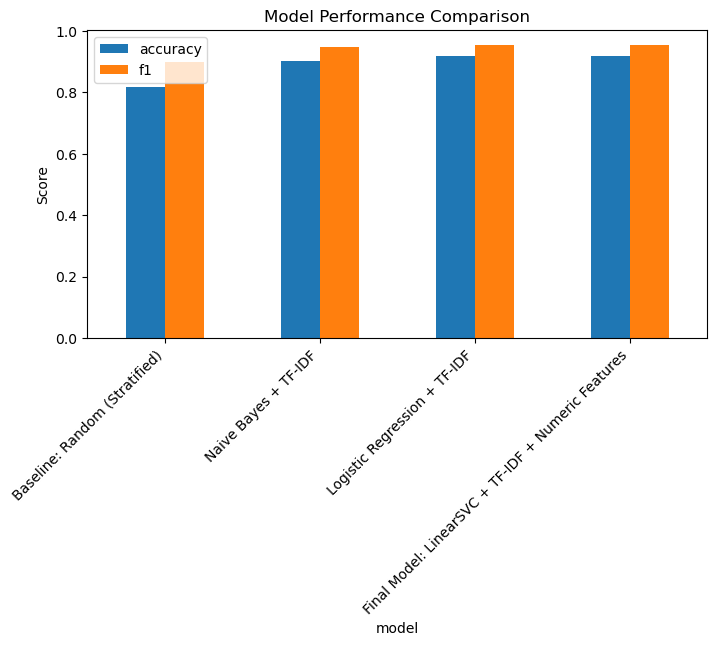

In [32]:
results_df.set_index("model")[["accuracy","f1"]].plot(kind="bar", figsize=(8,4))

plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")

plt.show()

### Testing our model

***How does our model perform on unseen data?***

Here, we will grab 5% of Steam users from the full dataset to see how our model performs, allowing for quick comparison.

In [34]:
interactions_small = interactions.sample(frac = 0.05, random_state = 42)

print('Small subset of data being used:')
interactions_small.head()

Small subset of data being used:


,user_id,user_url,funny,posted,last_edited,item_id,helpful,recommend,review,timestamp,item_name,playtime_forever,playtime_2weeks
14000,76561198079324079,http://steamcommunity.com/profiles/76561198079...,,"Posted January 9, 2014.",,570,No ratings yet,1,Viciante,2014-01-09,NaN,NaN,NaN
20859,ArchyRival,http://steamcommunity.com/id/ArchyRival,,"Posted October 5, 2015.",,730,0 of 1 people (0%) found this review helpful,0,♥♥♥♥ TEAM DIS GAME SUCK MAKE ME GET ♥♥♥♥ TEAM ...,2015-10-05,NaN,NaN,NaN
32133,TheMegaman96,http://steamcommunity.com/id/TheMegaman96,,"Posted April 19, 2015.",,730,No ratings yet,1,Awesome Fps Must grab game,2015-04-19,NaN,NaN,NaN
32384,TheillegalD,http://steamcommunity.com/id/TheillegalD,,"Posted June 21, 2013.",,57300,No ratings yet,1,good scary game,2013-06-21,NaN,NaN,NaN
41508,lescrepe,http://steamcommunity.com/id/lescrepe,,"Posted January 26, 2014.",,48000,No ratings yet,1,Getting stabbed in the chest by spiders has ne...,2014-01-26,NaN,NaN,NaN


In [35]:
X_small = interactions_small['review']
y_small = interactions_small['recommend']

In [36]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_small, y_small,
    test_size=0.2,
    random_state=42,
    stratify=y_small
)

In [37]:
vectorizer = TfidfVectorizer(stop_words="english")

X_train_vec_s = vectorizer.fit_transform(X_train_s)
X_test_vec_s  = vectorizer.transform(X_test_s)

In [41]:
def evaluate(model, name):
    model.fit(X_train_vec_s, y_train_s)
    preds = model.predict(X_test_vec_s)
    return {
        "model": name,
        "accuracy": accuracy_score(y_test_s, preds),
        "f1": f1_score(y_test_s, preds)
    }

In [45]:
print("\nTraining models...\n")

baseline_results = evaluate(
    DummyClassifier(strategy="stratified", random_state=42),
    "Baseline: Random"
)

logreg_results = evaluate(
    LogisticRegression(max_iter=500, random_state=42),
    "Logistic Regression"
)

nb_results = evaluate(
    MultinomialNB(),
    "Naive Bayes"
)

svc_results = evaluate(
    LinearSVC(C=1.0, random_state=42),
    "LinearSVC"
)

results_small_df = pd.DataFrame([
    baseline_results,
    logreg_results,
    nb_results,
    svc_results
])

print("\nModel Performance on Small Subset:")
print(results_small_df)


Training models...


Model Performance on Small Subset:
                 model  accuracy        f1
0     Baseline: Random  0.841463  0.912360
1  Logistic Regression  0.906504  0.950959
2          Naive Bayes  0.906504  0.950959
3            LinearSVC  0.908537  0.951561


C:\Users\User\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


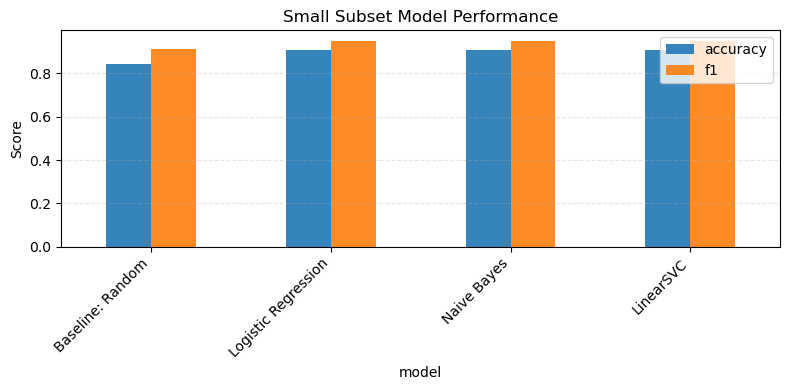

In [44]:
results_small_df.set_index("model")[["accuracy", "f1"]].plot(
    kind="bar",
    figsize=(8, 4),
    alpha=0.9
)

plt.title("Small Subset Model Performance")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

## Conclusion